In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import patsy

from mlb_predictions.utilities.data_utils import Schedule

In [2]:
full_set = []
years = [2021, 2022, 2023]
for year in years:
    print("working on year", year)
    sched = Schedule(year=[year])
    games = sched.get_games(game_type="Regular Season", game_status="Final")

    run_diffs = {}
    game_num = {}
    for game in games:
        full_set.append(
            (
                game.home_name,
                game.away_name,
                game.home_score,
                game.away_score,
                run_diffs.get(game.home_name, 0),
                run_diffs.get(game.away_name, 0),
                game_num.get(game.home_name, 1),
                game_num.get(game.away_name, 1),
            )
        )

        run_diffs[game.winning_team] = (
            run_diffs.get(game.winning_team, 0)
            + max(game.away_score, game.home_score)
            - min(game.home_score, game.away_score)
        )

        run_diffs[game.losing_team] = (
            run_diffs.get(game.losing_team, 0)
            + min(game.away_score, game.home_score)
            - max(game.home_score, game.away_score)
        )
        game_num[game.winning_team] = game_num.get(game.winning_team, 1) + 1
        game_num[game.losing_team] = game_num.get(game.losing_team, 1) + 1

working on year 2021
working on year 2022
working on year 2023


In [3]:
train_set = pd.DataFrame(
    full_set,
    columns=[
        "home_team",
        "away_team",
        "home_score",
        "away_score",
        "home_run_diff",
        "away_run_diff",
        "home_game_num",
        "away_game_num",
    ],
)
train_set["home_result"] = train_set["home_score"] - train_set["away_score"]

In [4]:
train_set.head()

,home_team,away_team,home_score,away_score,home_run_diff,away_run_diff,home_game_num,away_game_num,home_result
0,New York Yankees,Toronto Blue Jays,2,3,0,0,1,1,-1
1,Detroit Tigers,Cleveland Indians,3,2,0,0,1,1,1
2,Milwaukee Brewers,Minnesota Twins,6,5,0,0,1,1,1
3,Chicago Cubs,Pittsburgh Pirates,3,5,0,0,1,1,-2
4,Philadelphia Phillies,Atlanta Braves,3,2,0,0,1,1,1


In [5]:
X_train_full = train_set.iloc[:, 4:-1]
y_train_full = train_set.iloc[:, -1]

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.10, random_state=42
)

In [7]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(
    layers=[
        tf.keras.layers.Dense(8, activation="elu", input_shape=X_train.shape[1:]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation="elu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(8, activation="elu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1),
    ]
)

In [8]:
optimizer = tf.keras.optimizers.Adam()
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),  # "mean_squared_error",
    optimizer=optimizer,
    metrics=["mean_absolute_error"],
)

In [9]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=135,
    batch_size=64,
    verbose=2,
    validation_data=(X_valid, y_valid),
)

Epoch 1/135
102/102 - 0s - loss: 2480.5032 - mean_absolute_error: 24.0698 - val_loss: 82.5323 - val_mean_absolute_error: 6.5292 - 280ms/epoch - 3ms/step
Epoch 2/135
102/102 - 0s - loss: 619.6848 - mean_absolute_error: 12.9460 - val_loss: 35.3184 - val_mean_absolute_error: 4.5451 - 48ms/epoch - 469us/step
Epoch 3/135
102/102 - 0s - loss: 315.3518 - mean_absolute_error: 9.6848 - val_loss: 25.2263 - val_mean_absolute_error: 3.9228 - 48ms/epoch - 470us/step
Epoch 4/135
102/102 - 0s - loss: 226.7088 - mean_absolute_error: 8.2301 - val_loss: 22.3875 - val_mean_absolute_error: 3.7334 - 48ms/epoch - 474us/step
Epoch 5/135
102/102 - 0s - loss: 147.0889 - mean_absolute_error: 6.8960 - val_loss: 21.3666 - val_mean_absolute_error: 3.6624 - 48ms/epoch - 472us/step
Epoch 6/135
102/102 - 0s - loss: 108.7578 - mean_absolute_error: 6.0301 - val_loss: 21.0303 - val_mean_absolute_error: 3.6423 - 48ms/epoch - 472us/step
Epoch 7/135
102/102 - 0s - loss: 80.8471 - mean_absolute_error: 5.5504 - val_loss: 20.

In [10]:
train_set["home_result"].std()

4.462394199014392

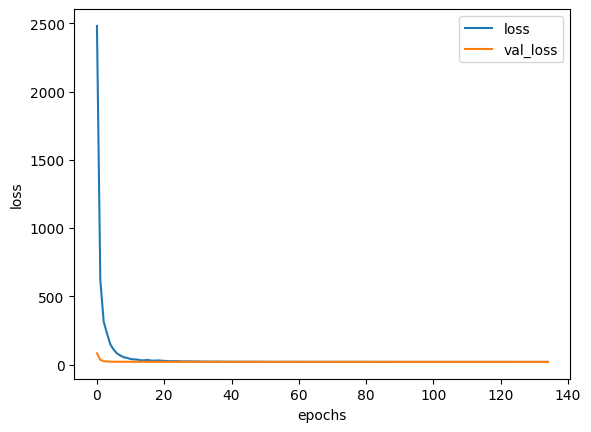

In [11]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["loss", "val_loss"])

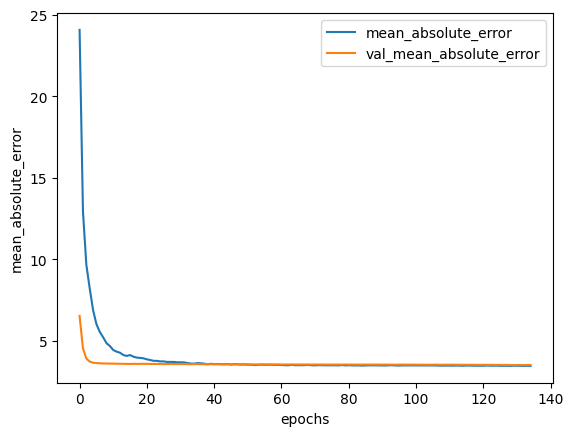

In [12]:
plt.plot(history.history["mean_absolute_error"])
plt.plot(history.history["val_mean_absolute_error"])
plt.xlabel("epochs")
plt.ylabel("mean_absolute_error")
plt.legend(["mean_absolute_error", "val_mean_absolute_error"])

<Axes: >

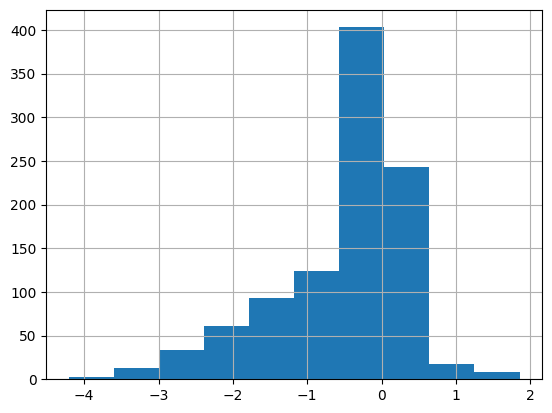

In [13]:
pd.Series(
    [
        model(np.array([[-321, 97, 150, 150]]), training=True).numpy()[0][0]
        for _ in range(1_000)
    ]
).hist()

In [14]:
pd.Series(
    [
        model(np.array([[-321, 97, 150, 150]]), training=True).numpy()[0][0]
        for _ in range(1_000)
    ]
).describe()

count    1000.000000
mean       -0.569925
std         0.910774
min        -3.845337
25%        -1.071516
50%        -0.226161
75%         0.044556
max         4.214359
dtype: float64

In [15]:
sched = Schedule(year=[2023])
games = sched.get_games(game_type="Regular Season", game_status="Final")


run_diffs_curr = {}
game_num_curr = {}
for game in games:
    run_diffs_curr[game.winning_team] = (
        run_diffs_curr.get(game.winning_team, 0)
        + max(game.away_score, game.home_score)
        - min(game.home_score, game.away_score)
    )

    run_diffs_curr[game.losing_team] = (
        run_diffs_curr.get(game.losing_team, 0)
        + min(game.away_score, game.home_score)
        - max(game.home_score, game.away_score)
    )
    game_num_curr[game.winning_team] = game_num_curr.get(game.winning_team, 1) + 1
    game_num_curr[game.losing_team] = game_num_curr.get(game.losing_team, 1) + 1

In [16]:
ITERATIONS = 1_000
MAGIC_NUMBER_CURR = 7

magic_number_dfs = pd.DataFrame()
sched = Schedule(year=[2023])
games = sched.get_games(game_type="Regular Season", game_status="Scheduled")

for i in range(ITERATIONS):
    print(f"on iteration {i}")
    magic_number = MAGIC_NUMBER_CURR
    test_full_set = []
    run_diffs = run_diffs_curr.copy()
    game_num = game_num_curr.copy()
    for game in games:
        pred = model(
            np.array(
                [
                    [
                        run_diffs.get(game.home_name, 0),
                        run_diffs.get(game.away_name, 0),
                        game_num.get(game.home_name, 1),
                        game_num.get(game.away_name, 1),
                    ]
                ]
            ),
            training=True,
        ).numpy()[0][0]

        if (
            (game.home_name == "Baltimore Orioles")
            and (pred > 0)  # O's win at home
            or (game.away_name == "Baltimore Orioles" and (pred < 0))  # O's win on road
            or (game.home_name == "Tampa Bay Rays")
            and (pred < 0)  # rays lose at home
            or (game.away_name == "Tampa Bay Rays")
            and (pred > 0)  # rays lose on road
        ):
            magic_number -= 1

        test_full_set.append(
            (
                game.home_name,
                game.away_name,
                game.game_date,
                None,
                None,
                run_diffs.get(game.home_name, 0),
                run_diffs.get(game.away_name, 0),
                game_num.get(game.home_name, 1),
                game_num.get(game.away_name, 1),
                pred,
                magic_number
                if "Baltimore Orioles" in (game.home_name, game.away_name)
                else None,
            )
        )

        if pred > 0:
            winning_team = game.home_name
            losing_team = game.away_name
        else:
            winning_team = game.away_name
            losing_team = game.home_name

        run_diffs[winning_team] = run_diffs.get(winning_team, 0) + abs(pred)

        run_diffs[losing_team] = run_diffs.get(losing_team, 0) + -abs(pred)
        game_num[winning_team] = game_num.get(winning_team, 1) + 1
        game_num[losing_team] = game_num.get(losing_team, 1) + 1

    future_set = pd.DataFrame(
        test_full_set,
        columns=[
            "home_team",
            "away_team",
            "game_date",
            "home_score",
            "away_score",
            "home_run_diff",
            "away_run_diff",
            "home_game_num",
            "away_game_num",
            "home_result",
            "magic_number",
        ],
    )

    msk = future_set.magic_number == 0
    magic_number_dfs = pd.concat([magic_number_dfs, future_set[msk]])

on iteration 0
on iteration 1
on iteration 2
on iteration 3
on iteration 4
on iteration 5
on iteration 6
on iteration 7
on iteration 8
on iteration 9
on iteration 10
on iteration 11
on iteration 12
on iteration 13
on iteration 14
on iteration 15
on iteration 16
on iteration 17
on iteration 18
on iteration 19
on iteration 20
on iteration 21
on iteration 22
on iteration 23
on iteration 24
on iteration 25
on iteration 26
on iteration 27
on iteration 28
on iteration 29
on iteration 30
on iteration 31
on iteration 32
on iteration 33
on iteration 34
on iteration 35
on iteration 36
on iteration 37
on iteration 38
on iteration 39
on iteration 40
on iteration 41
on iteration 42
on iteration 43
on iteration 44
on iteration 45
on iteration 46
on iteration 47
on iteration 48
on iteration 49
on iteration 50
on iteration 51
on iteration 52
on iteration 53
on iteration 54
on iteration 55
on iteration 56
on iteration 57
on iteration 58
on iteration 59
on iteration 60
on iteration 61
on iteration 62
on

In [17]:
magic_number_dfs

,home_team,away_team,game_date,home_score,away_score,home_run_diff,away_run_diff,home_game_num,away_game_num,home_result,magic_number
76,Baltimore Orioles,Boston Red Sox,2023-10-01,None,None,127.876466,-0.090242,162,162,0.174112,0.0
68,Baltimore Orioles,Boston Red Sox,2023-09-30,None,None,129.899502,-1.790188,161,161,0.625817,0.0
76,Baltimore Orioles,Boston Red Sox,2023-10-01,None,None,128.900940,-1.246791,162,162,0.424138,0.0
76,Baltimore Orioles,Boston Red Sox,2023-10-01,None,None,129.783656,1.029572,162,162,0.117067,0.0
68,Baltimore Orioles,Boston Red Sox,2023-09-30,None,None,128.604421,0.178769,161,161,0.228684,0.0
...,...,...,...,...,...,...,...,...,...,...,...
76,Baltimore Orioles,Boston Red Sox,2023-10-01,None,None,128.343374,-1.967786,162,162,1.398353,0.0
68,Baltimore Orioles,Boston Red Sox,2023-09-30,None,None,128.502014,-0.034392,161,161,0.144756,0.0
76,Baltimore Orioles,Boston Red Sox,2023-10-01,None,None,128.294559,0.202650,162,162,1.001186,0.0
68,Baltimore Orioles,Boston Red Sox,2023-09-30,None,None,128.758644,-2.530394,161,161,0.210379,0.0


In [18]:
print(f"CHANCES OF WINNING DIVISION: {len(magic_number_dfs) / ITERATIONS:.1%}")

CHANCES OF WINNING DIVISION: 42.6%


In [19]:
division_wins = (
    magic_number_dfs.groupby(["home_team", "away_team", "game_date"])
    .magic_number.count()
    .reset_index()
)
division_wins

,home_team,away_team,game_date,magic_number
0,Baltimore Orioles,Boston Red Sox,2023-09-30,154
1,Baltimore Orioles,Boston Red Sox,2023-10-01,272


In [20]:
division_wins["clinchmas_chance"] = (
    100 * division_wins["magic_number"] / len(magic_number_dfs)
).round(1)

In [21]:
print(f"CHANCES OF WINNING DIVISION: {len(magic_number_dfs) / ITERATIONS:.1%}")

CHANCES OF WINNING DIVISION: 42.6%


In [22]:
division_wins.sort_values("clinchmas_chance", ascending=False)[
    ["home_team", "away_team", "game_date", "clinchmas_chance"]
]

,home_team,away_team,game_date,clinchmas_chance
1,Baltimore Orioles,Boston Red Sox,2023-10-01,63.8
0,Baltimore Orioles,Boston Red Sox,2023-09-30,36.2
